# Automatic Results Analysis 

This notebook serves as a starting point to analyze your results using the pipeline. It can be extended for your needs or highly modified. 

In [43]:
# Libraries import
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression

Use this following notebook cell to input the path to the model you want to analyze results :

In [44]:
MODEL_DIR = "model_weights/efficientnet/b5/no_wandb_20250807_103340"  # Replace with your model path
TRAINING_LOG_PATH = f"{MODEL_DIR}/training_log.csv"
CLASSIF_REPORT = f"classif_report_best_efficientnet.csv"

## Validation & Train loss over Epochs

In [45]:
df = pd.read_csv(TRAINING_LOG_PATH, comment='#')

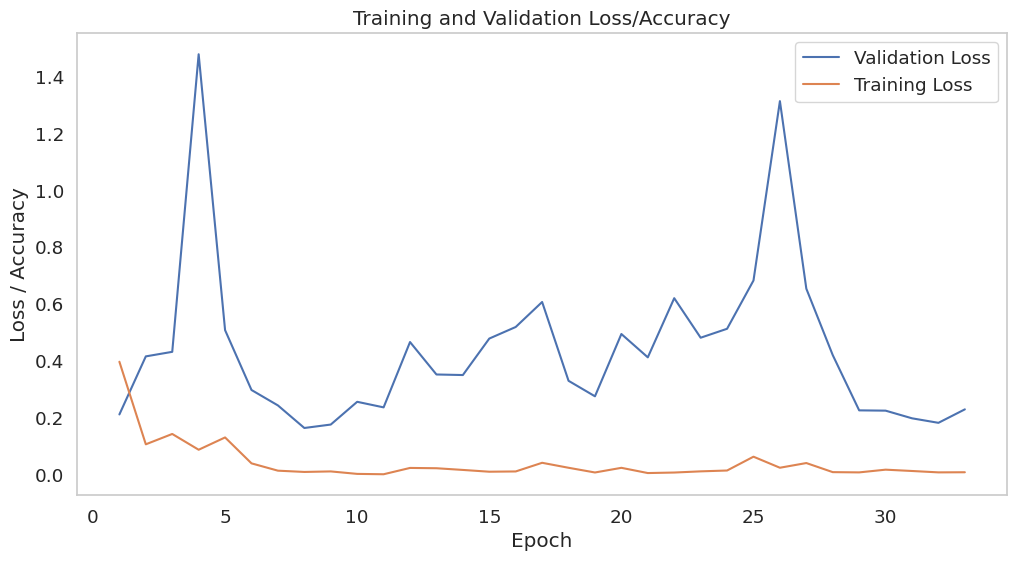

In [46]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.plot(df['epoch'], df['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Loss/Accuracy')
plt.legend()
plt.grid()
plt.show()

## Accuracies

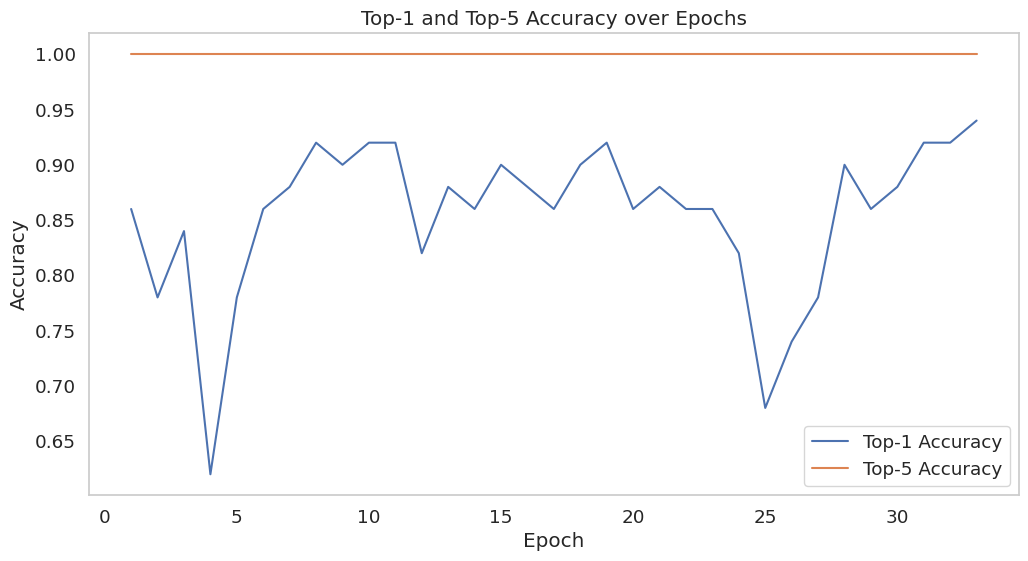

In [47]:
# Top1 and Top5 Accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['top1_acc'], label='Top-1 Accuracy')
plt.plot(df['epoch'], df['top5_acc'], label='Top-5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Top-1 and Top-5 Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

## Metrics over Epochs

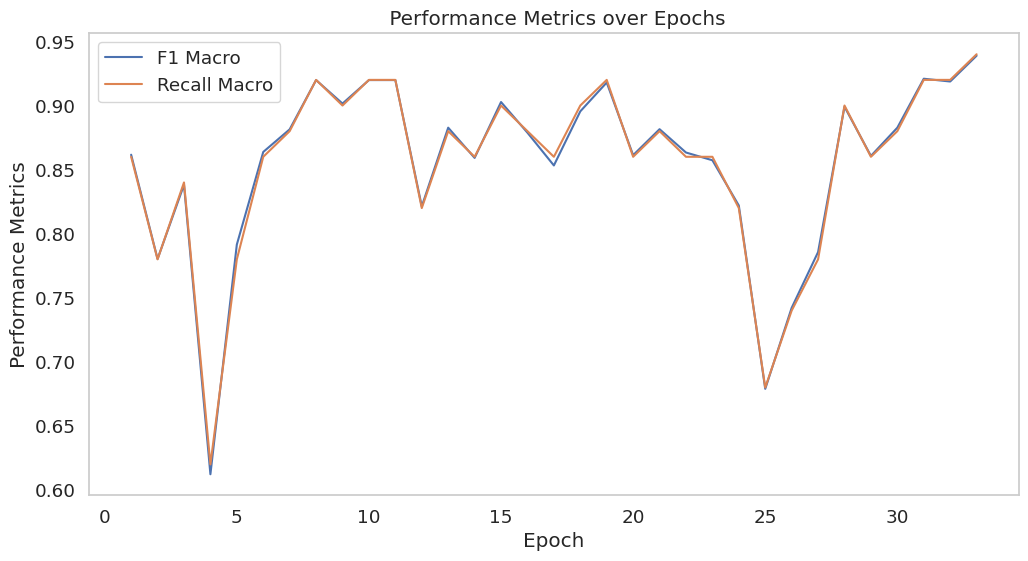

In [57]:
# Generate a graph for metrics over epochs 
# Top1 and Top5 Accuracy over epochs
plt.figure(figsize=(12, 6))

plt.plot(df['epoch'], df['f1_macro'],  label='F1 Macro')
plt.plot(df['epoch'], df['recall_macro'], label='Recall Macro')

plt.xlabel('Epoch')
plt.ylabel('Performance Metrics')
plt.title(' Performance Metrics over Epochs')
plt.legend()
plt.grid()
plt.show()

## F1-Score vs Class Support

We are working with the generated classification report from sklearn. 

In [49]:
df_report_classif = pd.read_csv(CLASSIF_REPORT)
# Filter out summary rows (if they exist)
df_report_classif_cleaned = df_report_classif[~df_report_classif['class'].isin(['accuracy', 'macro avg', 'weighted avg'])].copy()
# Convert to numeric, handling any non-numeric values
df_report_classif_cleaned['f1-score'] = pd.to_numeric(df_report_classif_cleaned['f1-score'], errors='coerce')
df_report_classif_cleaned['support'] = pd.to_numeric(df_report_classif_cleaned['support'], errors='coerce')
# Drop rows with NaN values in case there are any (shouldn't be the case)
df_report_classif_cleaned.dropna(subset=['f1-score', 'support'], inplace=True)

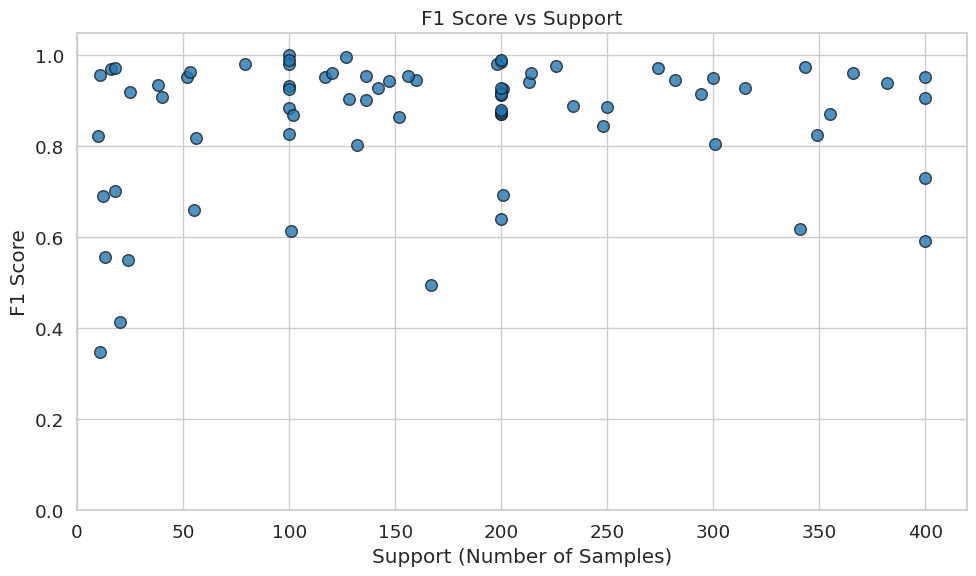

In [50]:
# Plot F1-Score vs Support
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

plt.scatter(df_report_classif_cleaned['support'], df_report_classif_cleaned['f1-score'], color='tab:blue', edgecolor='k', s=70, alpha=0.8)

plt.xlabel('Support (Number of Samples)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Support')
plt.xlim(left=0)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()

## Worst Classes and Best Classes

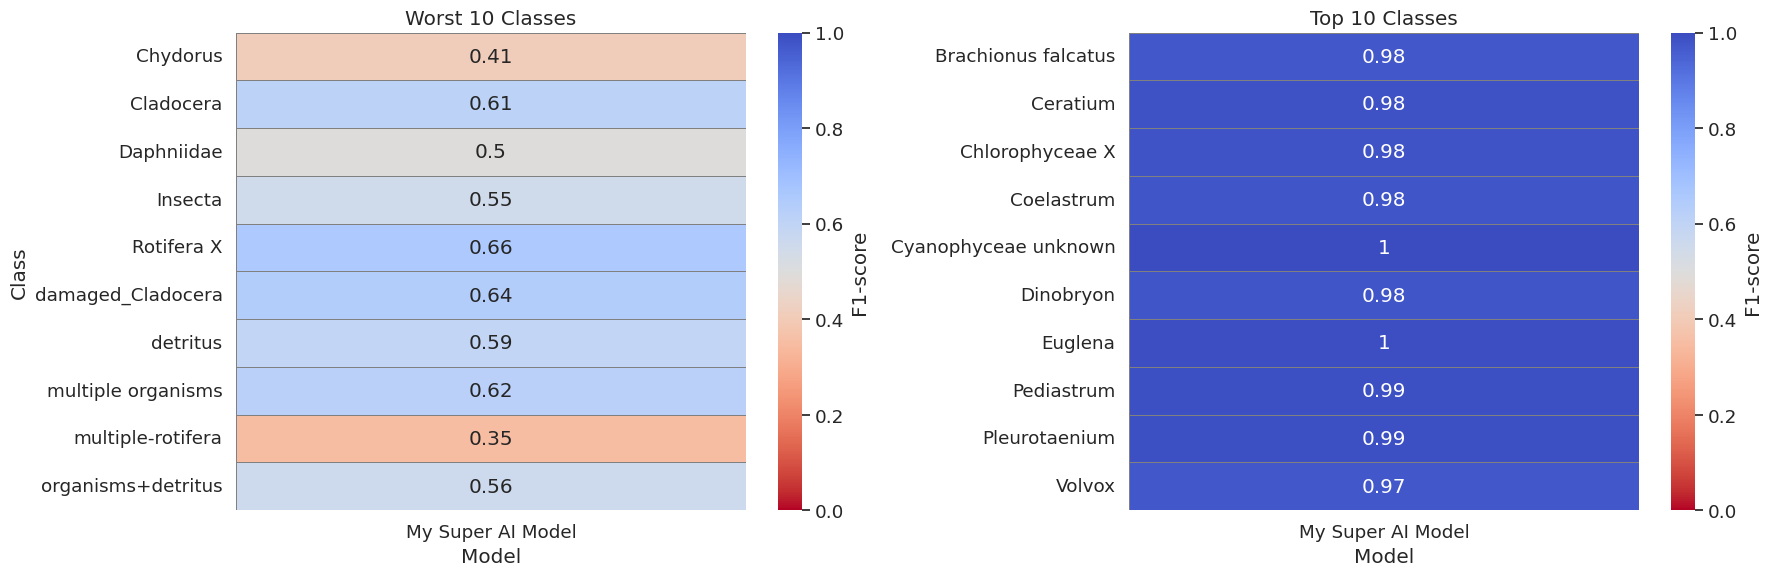

In [51]:
# Prepare data for heatmap: single column with model name
model_name = "My Super AI Model"  # Change this to your actual model name if needed
bottom_n = 10
top_n = 10

# Select the bottom N classes by F1-score
worst_classes = df_report_classif_cleaned.nsmallest(bottom_n, 'f1-score')
top_classes = df_report_classif_cleaned.nlargest(top_n, 'f1-score')
worst_classes['model'] = model_name
top_classes['model'] = model_name

# Pivot for heatmaps
pivot_df_top = top_classes.pivot(index='class', columns='model', values='f1-score')
pivot_df_worst = worst_classes.pivot(index='class', columns='model', values='f1-score')

# Determine figure height based on max rows
n_rows = max(len(pivot_df_worst), len(pivot_df_top))
fig_height = max(6, n_rows * 0.4)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, fig_height), sharex=False)

sns.heatmap(
    pivot_df_worst,
    annot=True,
    cmap='coolwarm_r',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'F1-score'},
    ax=axes[0]
)
axes[0].set_title(f'Worst {bottom_n} Classes')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Class')

sns.heatmap(
    pivot_df_top,
    annot=True,
    cmap='coolwarm_r',
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'F1-score'},
    ax=axes[1]
)
axes[1].set_title(f'Top {top_n} Classes')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('')  # Hide redundant y-label

plt.tight_layout()
plt.show()


# Confusion Matrix

In [52]:
CONF_MATRIX_CSV = f"{MODEL_DIR}/confusion_matrix_raw.csv"
CONF_MATRIX_RAW_IMG = f"{MODEL_DIR}/confusion_matrix_raw.png"
CONF_MATRIX_NORM_IMG = f"{MODEL_DIR}/confusion_matrix_normalized.png"

In [53]:
# Display the confusion matrices
print("# Confusion Matrix")
print(f"Raw confusion matrix saved at: {CONF_MATRIX_RAW_IMG}")
print(f"Normalized confusion matrix saved at: {CONF_MATRIX_NORM_IMG}")

# Confusion Matrix
Raw confusion matrix saved at: model_weights/efficientnet/b5/no_wandb_20250807_103340/confusion_matrix_raw.png
Normalized confusion matrix saved at: model_weights/efficientnet/b5/no_wandb_20250807_103340/confusion_matrix_normalized.png


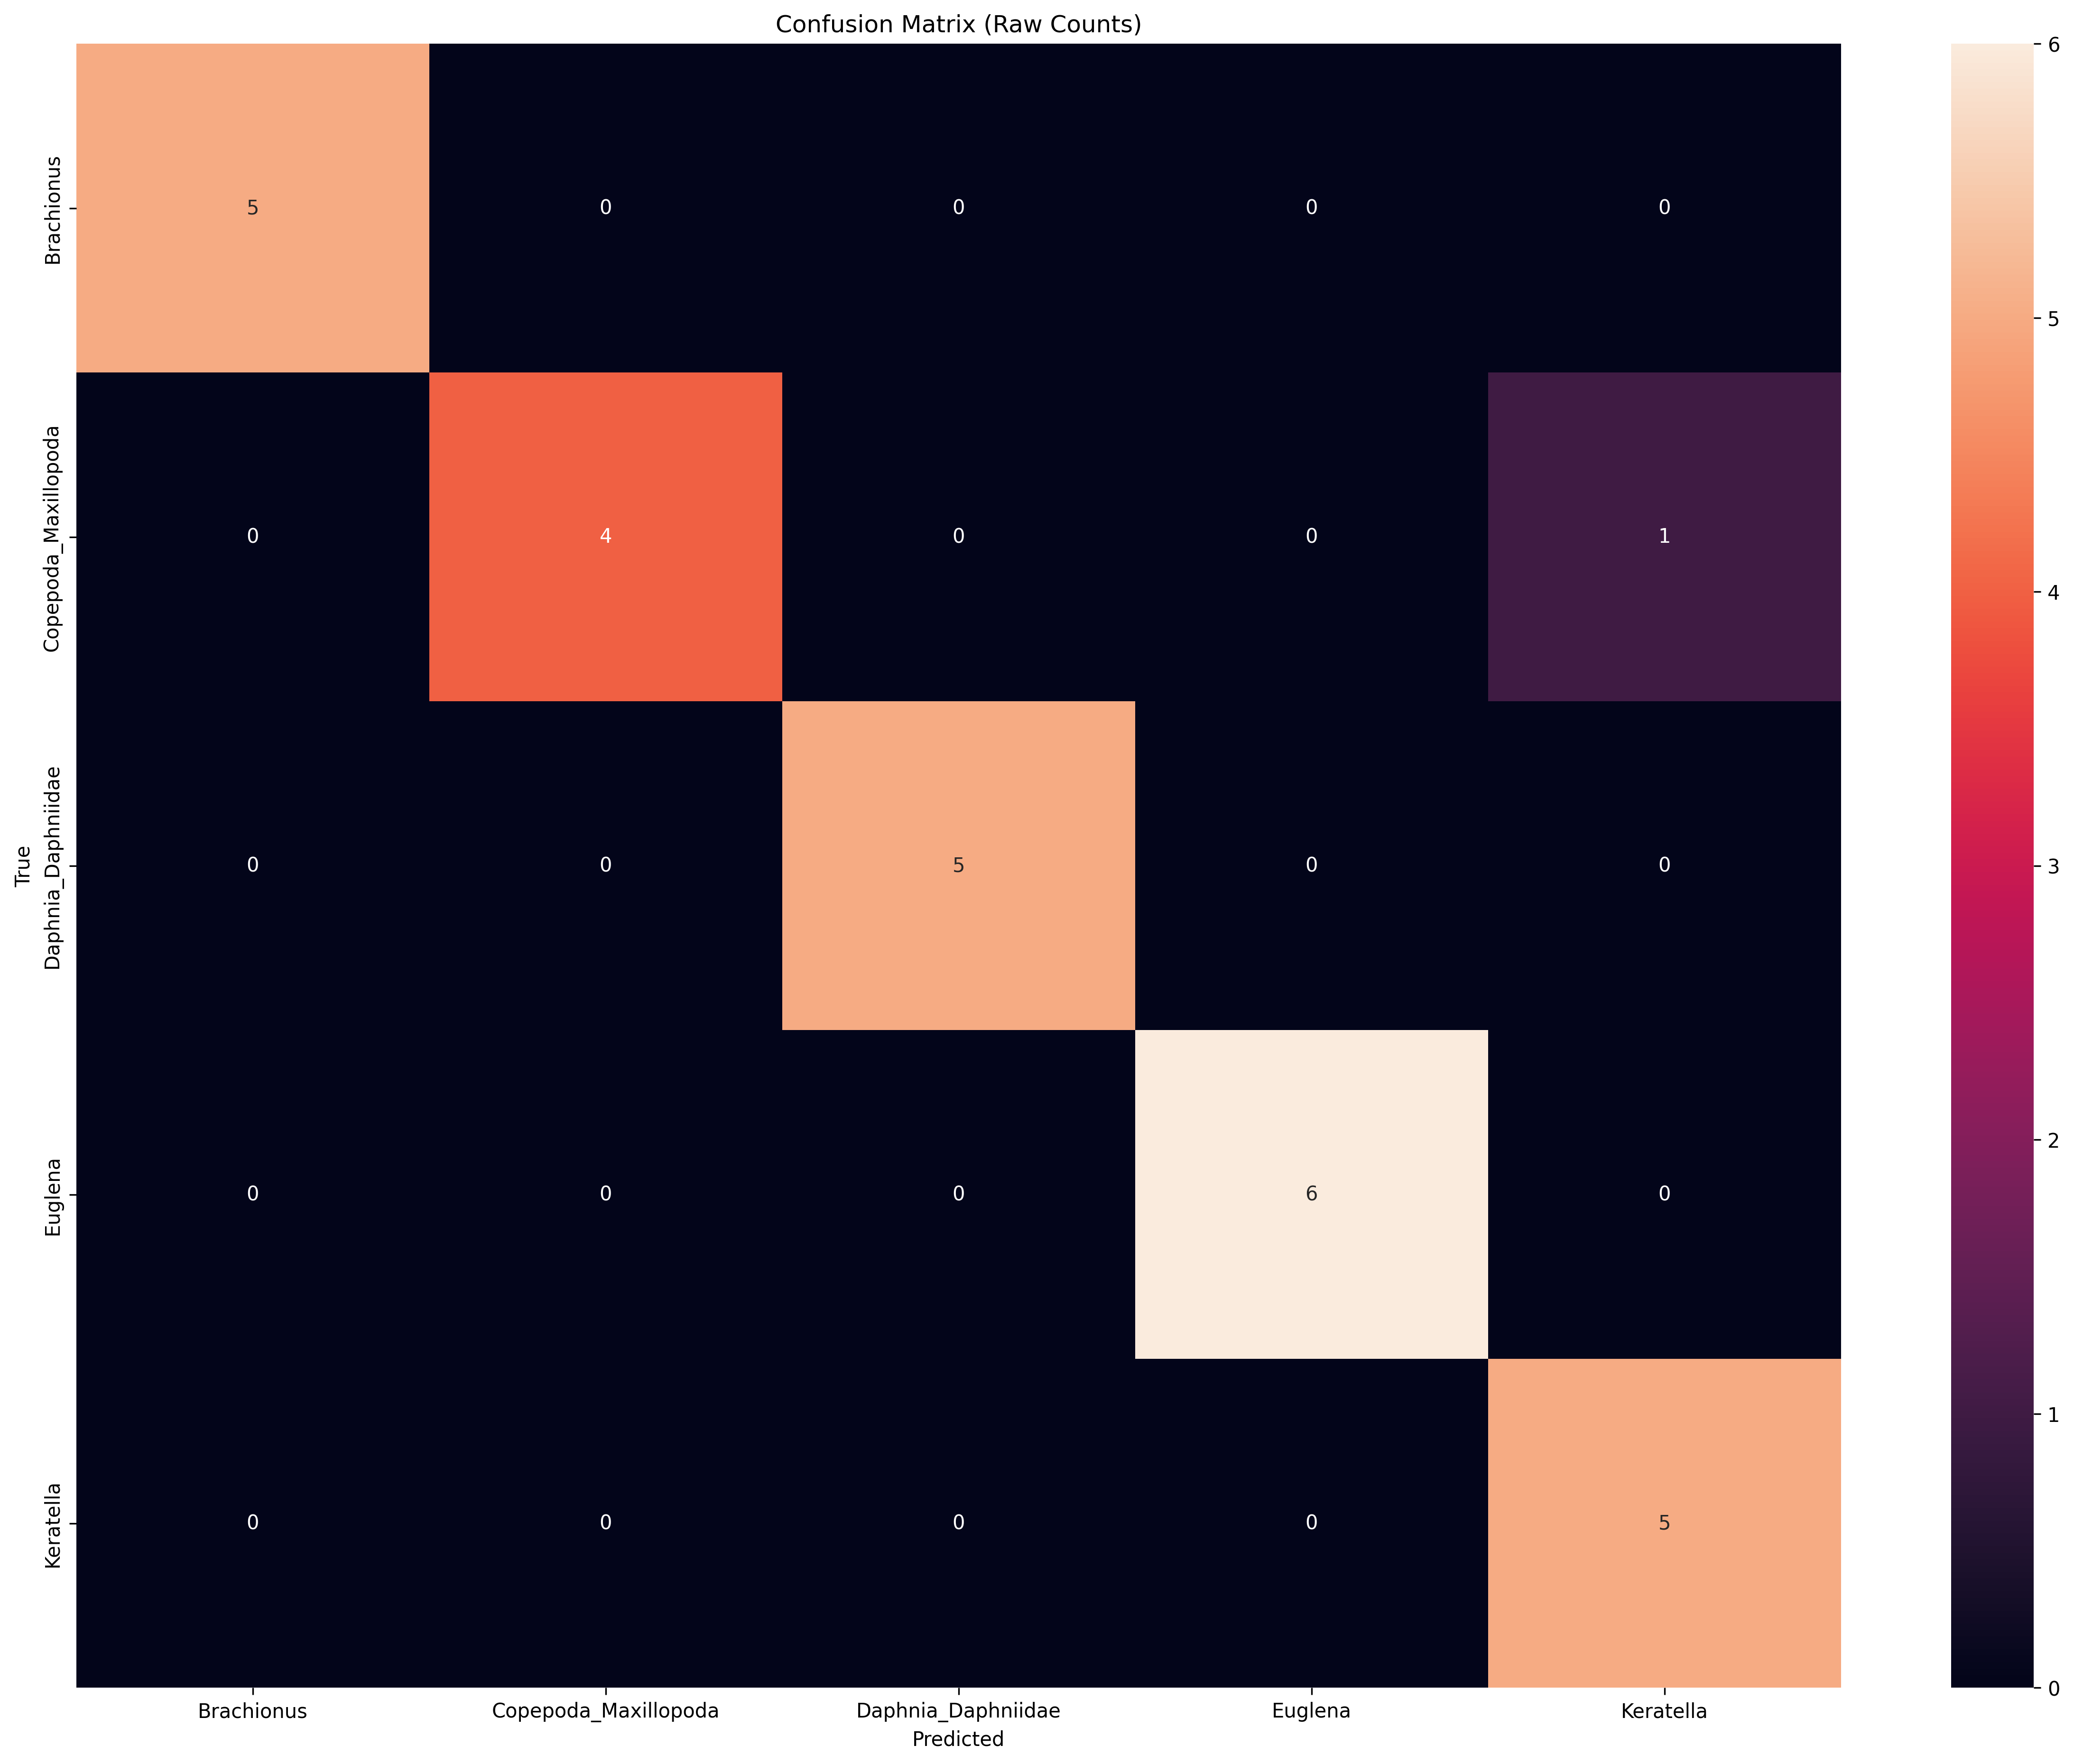

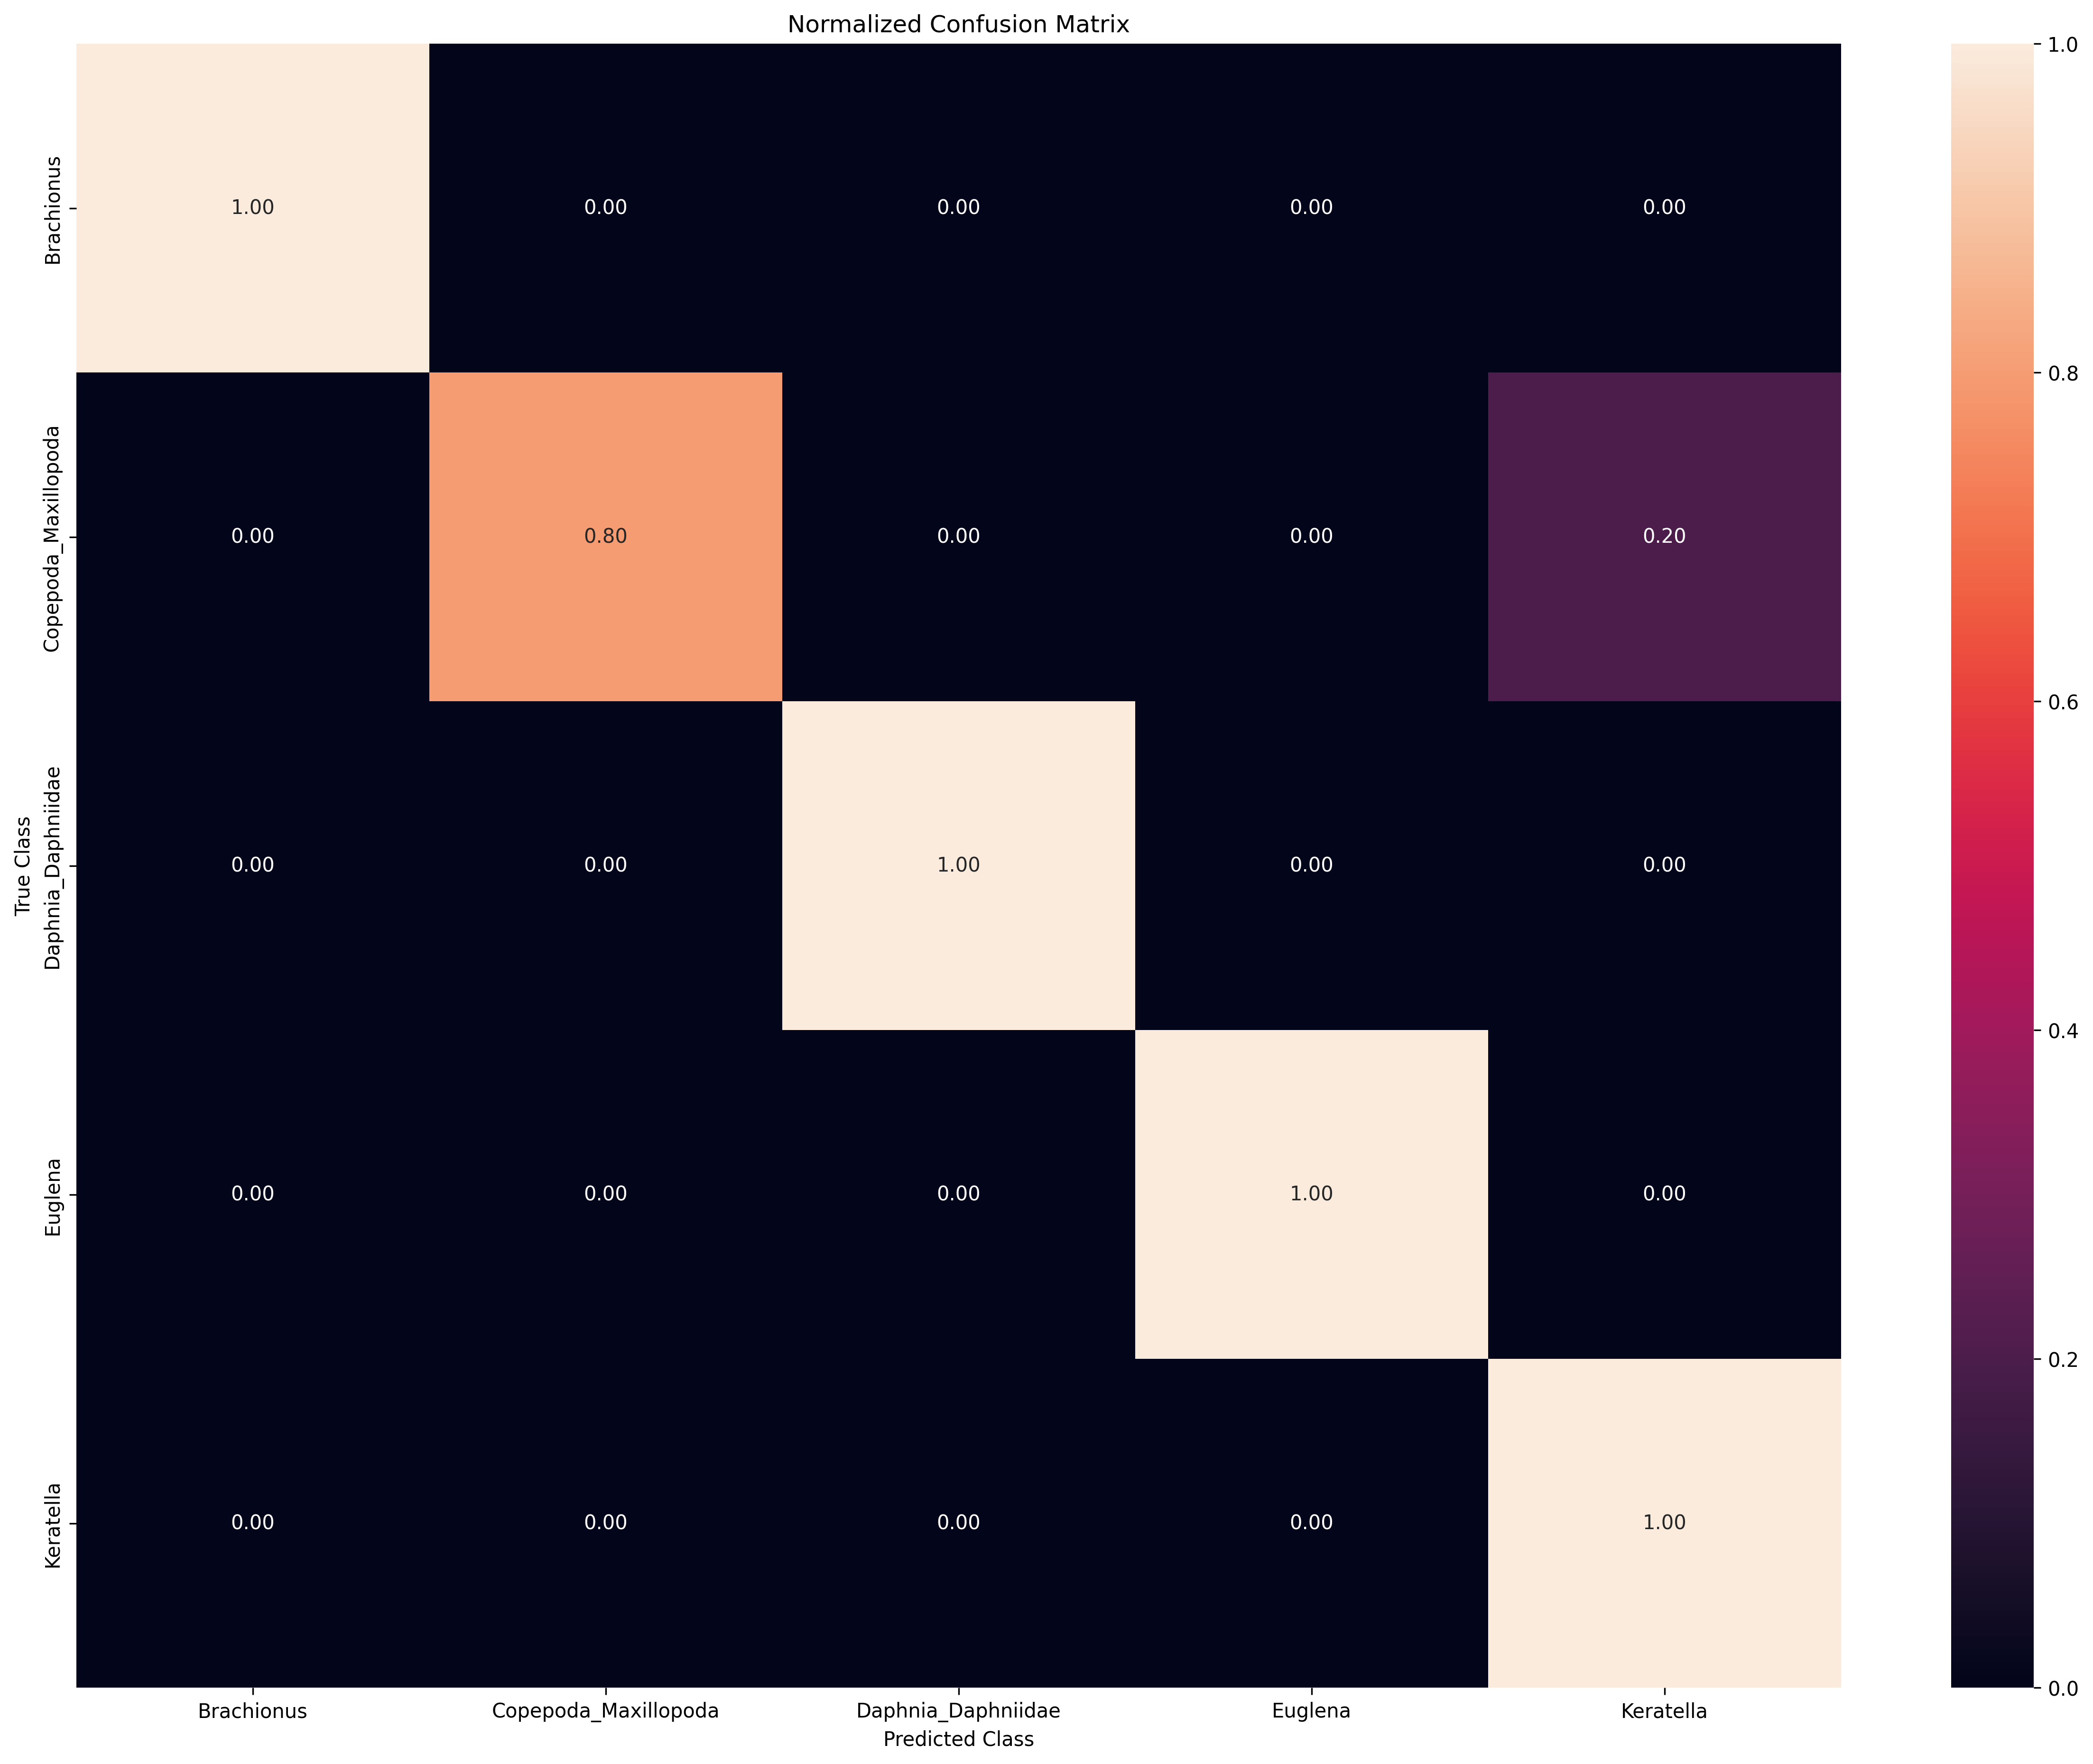

In [54]:
from IPython.display import Image, display

# Display the confusion matrices
display(Image(filename=CONF_MATRIX_RAW_IMG))
display(Image(filename=CONF_MATRIX_NORM_IMG))

Let's check which classes are the most confused

/tmp/ipykernel_1903022/2581729833.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


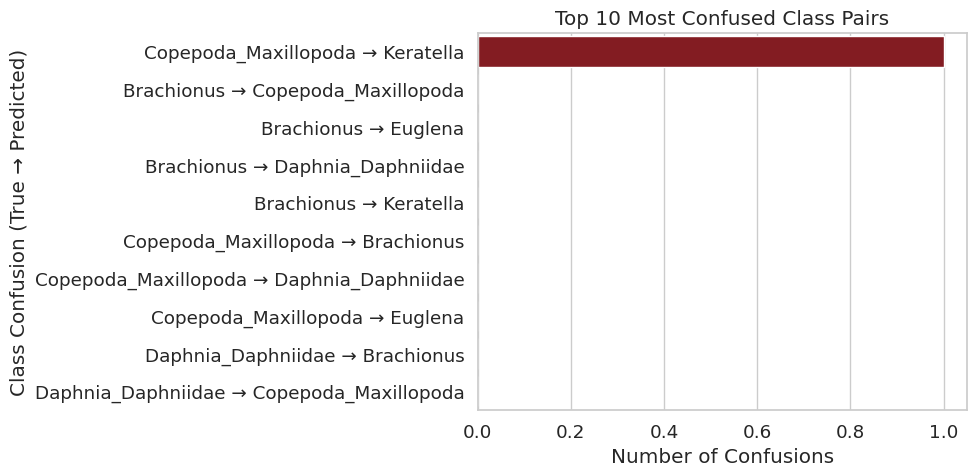

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
top_n = 10

# Load confusion matrix
cm_df = pd.read_csv(CONF_MATRIX_CSV, index_col=0)

# Flatten confusion matrix (excluding diagonal)
confusions = []
for true_class in cm_df.index:
    for pred_class in cm_df.columns:
        if true_class != pred_class:
            count = cm_df.loc[true_class, pred_class]
            confusions.append((true_class, pred_class, count))

# Create DataFrame from confusion data
confusion_df = pd.DataFrame(confusions, columns=['True Class', 'Predicted Class', 'Count'])

# Sort by most confused
top_confusions = confusion_df.sort_values(by='Count', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, max(4, top_n * 0.5)))
sns.barplot(
    data=top_confusions,
    x='Count',
    y=top_confusions.apply(lambda row: f"{row['True Class']} → {row['Predicted Class']}", axis=1),
    palette='Reds_r'
)
plt.xlabel("Number of Confusions")
plt.ylabel("Class Confusion (True → Predicted)")
plt.title(f"Top {top_n} Most Confused Class Pairs")
plt.tight_layout()
plt.show()
